Q3 Daniel Lin 322594508

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cat_image = cv2.imread('cat.jpg', cv2.IMREAD_GRAYSCALE)

****************** functions from previous questions that i will reuse: ******************

In [57]:
def manual_convolution(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_image = np.zeros((image_height + 2 * pad_height, image_width + 2 * pad_width))
    padded_image[pad_height:pad_height + image_height, pad_width:pad_width + image_width] = image

    output_image = np.zeros_like(image, dtype=np.float64)

    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            output_image[i, j] = np.sum(region * kernel)

    return output_image


def fix_image(image):
    clipped = np.clip(image, 0, 255)
    return clipped.astype(np.uint8)


def create_gaussian_kernel(size, sigma):
    distances_from_center = np.linspace(-(size // 2), size // 2, size)
    horizontal_distance_from_center, vertical_distance_from_center = np.meshgrid(distances_from_center, distances_from_center)

    horizontal_distance_squared = horizontal_distance_from_center ** 2
    vertical_distance_squared = vertical_distance_from_center ** 2

    distance_from_center_squared = (horizontal_distance_squared + vertical_distance_squared)
    denominator = 2 * (sigma ** 2)
    kernel = np.exp(-distance_from_center_squared / denominator)

    return kernel / np.sum(kernel)


Q3.1

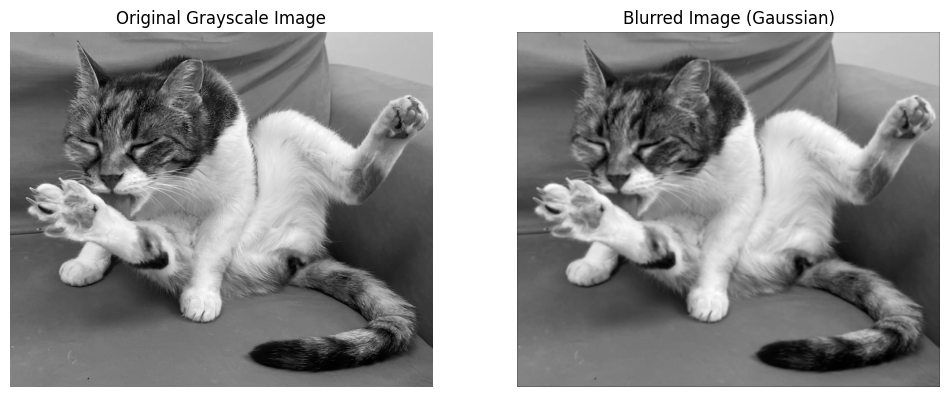

In [58]:
gaussian_kernel = create_gaussian_kernel(5,1)
gaussian_image = manual_convolution(cat_image, gaussian_kernel)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cat_image, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fix_image(gaussian_image), cmap='gray')
plt.title("Blurred Image (Gaussian)")
plt.axis('off')

plt.show()

noise reduction is critical because the calculation of the edges is so sensitive, that if we won't use noise reduction it will recognize the noise as a false edges

Q3.2

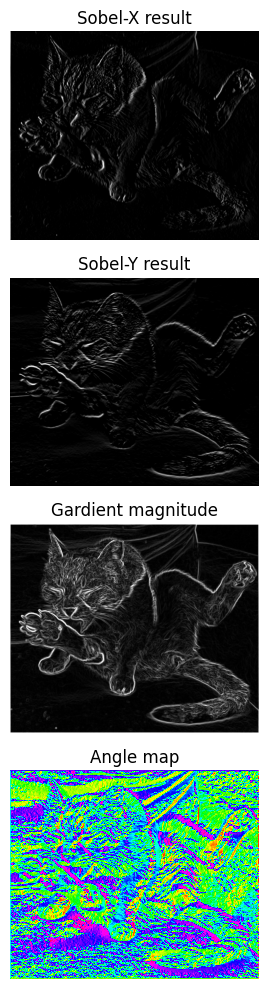

In [59]:
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float64)

sobel_y_kernel = np.array([
    [-1, -2, -1],
    [0,  0,  0],
    [1,  2,  1]
], dtype=np.float64)

result_sobel_x = manual_convolution(gaussian_image, sobel_x_kernel)
result_sobel_y = manual_convolution(gaussian_image, sobel_y_kernel)

G_x = manual_convolution(gaussian_image, sobel_x_kernel)
G_y = manual_convolution(gaussian_image, sobel_y_kernel)
edge_strength = np.sqrt(np.square(G_x) + np.square(G_y))
edge_direction = np.arctan2(G_y, G_x)

plt.figure(figsize=(16, 10))

plt.subplot(4, 1, 1)
plt.imshow(fix_image(G_x), cmap='gray')
plt.title("Sobel-X result")
plt.axis('off')

plt.subplot(4, 1, 2)
plt.imshow(fix_image(G_y), cmap='gray')
plt.title("Sobel-Y result")
plt.axis('off')

plt.subplot(4, 1, 3)
plt.imshow(fix_image(edge_strength), cmap='gray')
plt.title("Gardient magnitude")
plt.axis('off')

plt.subplot(4, 1, 4)
plt.imshow(edge_direction, cmap='hsv')
plt.title("Angle map")
plt.axis('off')

plt.tight_layout()
plt.show()

canny_result_image = edge_strength

Q3.3

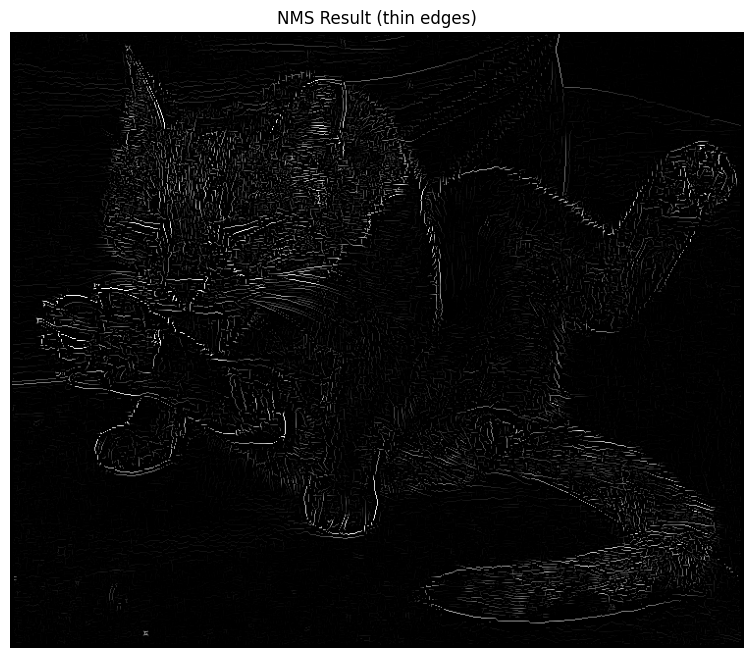

In [60]:
def non_maximum_suppression(magnitude, orientation):
    height, width = magnitude.shape
    nms_output = np.zeros((height, width), dtype=np.float64)

    angle_in_degrees = np.rad2deg(orientation)
    angle_in_degrees[angle_in_degrees < 0] += 180

    for row in range(1, height - 1):
        for col in range(1, width - 1):

            current_magnitude = magnitude[row, col]
            current_angle = angle_in_degrees[row, col]

            neighbor_1 = 255
            neighbor_2 = 255

            # 0 degrees
            if (0 <= current_angle < 22.5) or (157.5 <= current_angle <= 180):
                neighbor_1 = magnitude[row, col + 1]
                neighbor_2 = magnitude[row, col - 1]

            # 45 degrees
            elif (22.5 <= current_angle < 67.5):
                neighbor_1 = magnitude[row - 1, col + 1]
                neighbor_2 = magnitude[row + 1, col - 1]

            # 90 degrees
            elif (67.5 <= current_angle < 112.5):
                neighbor_1 = magnitude[row + 1, col]
                neighbor_2 = magnitude[row - 1, col]

            # 135 degrees
            elif (112.5 <= current_angle < 157.5):
                neighbor_1 = magnitude[row - 1, col - 1]
                neighbor_2 = magnitude[row + 1, col + 1]

            if (current_magnitude >= neighbor_1) and (current_magnitude >= neighbor_2):
                nms_output[row, col] = current_magnitude
            else:
                nms_output[row, col] = 0

    return nms_output


nms_result = non_maximum_suppression(edge_strength, edge_direction)

plt.figure(figsize=(10, 8))

plt.imshow(fix_image(nms_result), cmap='gray')
plt.title("NMS Result (thin edges)")
plt.axis('off')
plt.show()

we need NMS because after applying noise reduction and gradient computation, the edges looks thick and blurry. applying NMS to the image thins these edges and making them well defined and sharp.

Q3.4

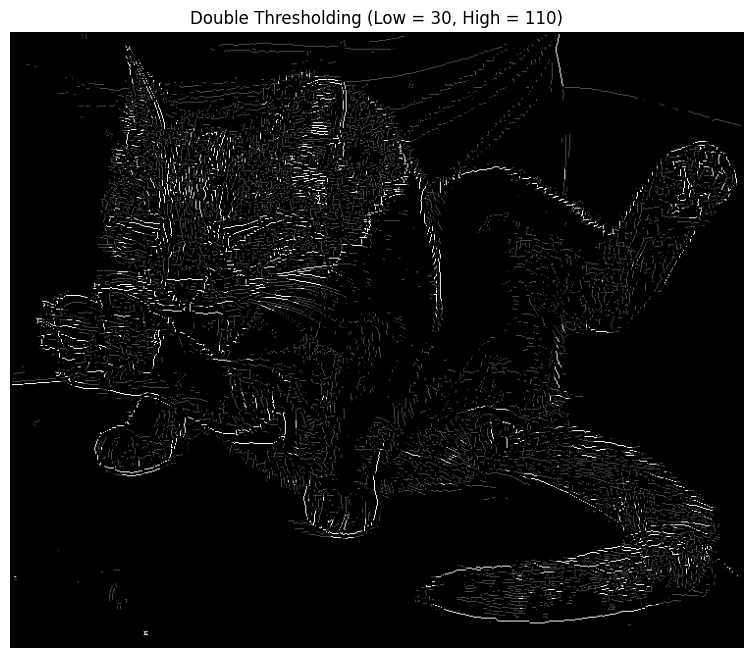

In [61]:
def double_thresholding(image, low_threshold, high_threshold):
    height, width = image.shape
    result = np.zeros((height, width), dtype=np.uint8)

    color_of_strong = 255
    color_of_weak = 75

    strong_i, strong_j = np.where(image >= high_threshold)
    weak_i, weak_j = np.where((image <= high_threshold) & (image >= low_threshold))

    result[strong_i, strong_j] = color_of_strong
    result[weak_i, weak_j] = color_of_weak
    # the values of the matrix at the beginning is zero in  all the cells, so we dont need to check the values that are lower than low_threshold

    return result


low_threshold = 30
high_threshold = 110
thresholded_image = double_thresholding(nms_result, low_threshold, high_threshold)

plt.figure(figsize=(10, 8))
plt.imshow(thresholded_image, cmap='gray')
plt.title("Double Thresholding (Low = 30, High = 110)")
plt.axis('off')
plt.show()

double thresholding marks the pixels that are definitely edges, marks the pixels that might be edges or noise, and marks the pixels that are for sure noise, it helps in the next process to identify which pixels noise and false positive

Q3.5

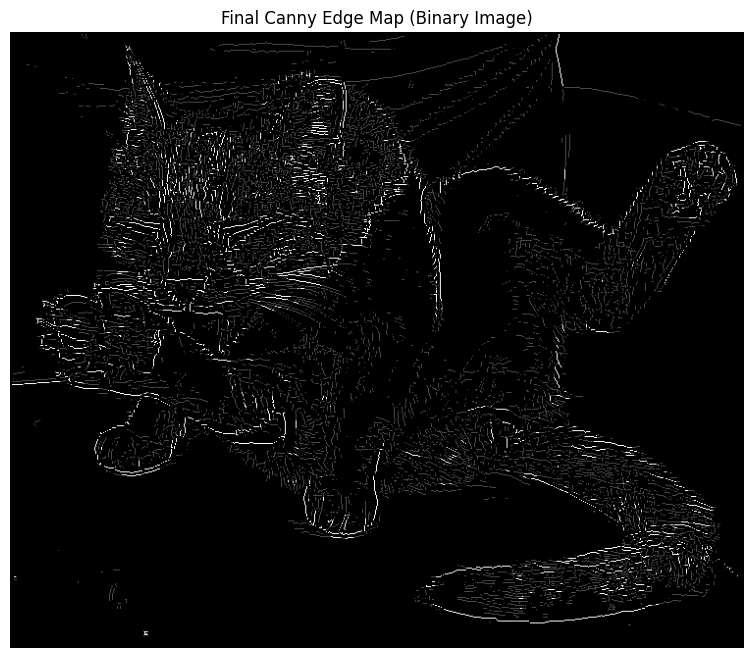

In [72]:
def hysteresis_recursive(image, strong_val, weak_val):
    height, width = image.shape
    result = np.copy(image)

    def follow_edge_chain(current_row, current_col):
        for row_offset in [-1, 0, 1]:
            for col_offset in [-1, 0, 1]:
                if row_offset == 0 and col_offset == 0:
                    continue

                neighbor_row = current_row + row_offset
                neighbor_col = current_col + col_offset

                if 0 <= neighbor_row < height and 0 <= neighbor_col < width:
                    if result[neighbor_row, neighbor_col] == weak_val:
                        result[neighbor_row, neighbor_col] = strong_val
                        follow_edge_chain(neighbor_row, neighbor_col)

    for row in range(height):
        for col in range(width):
            if result[row, col] == strong_val:
                follow_edge_chain(row, col)

    result[result == weak_val] = 0
    return result

color_of_strong = 255
color_of_weak = 75
final_canny_map = hysteresis_recursive(thresholded_image, color_of_strong, color_of_weak)

plt.figure(figsize=(10, 8))
plt.imshow(final_canny_map, cmap='gray')
plt.title("Final Canny Edge Map (Binary Image)")
plt.axis('off')
plt.show()

hysteresis makes sure long edges stay connected even if they dont have the same intensity for the entire edge. It also helps find which pixels are noise and not real edges so it can remove them.

Q3.6

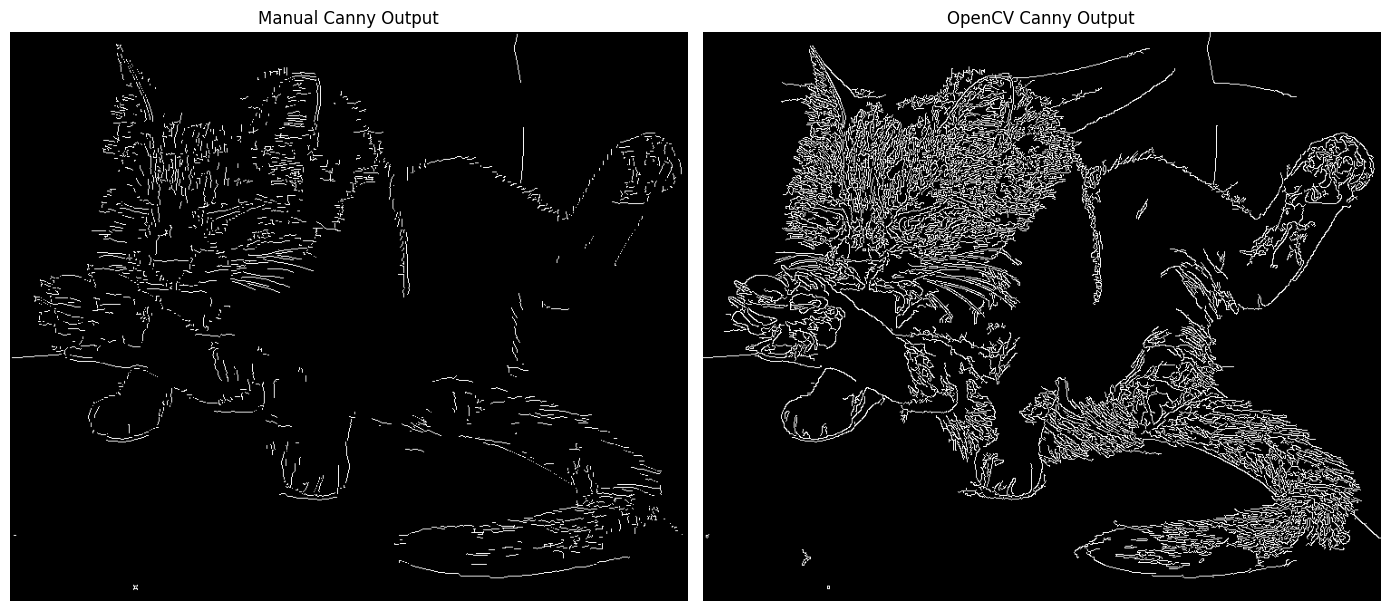

In [70]:
opencv_canny_result = cv2.Canny(cat_image, low_threshold, high_threshold)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(final_canny_map, cmap='gray')
plt.title("Manual Canny Output")
plt.axis('off')

# 2. התוצאה של OpenCV
plt.subplot(1, 2, 2)
plt.imshow(opencv_canny_result, cmap='gray')
plt.title("OpenCV Canny Output")
plt.axis('off')

plt.tight_layout()
plt.show()

here are many values in my code that are different then opencv's. these differences cause big differences in the final result.
when i did the gaussian stage, the kernel sizes and the sigma can be different,

difference in gaussian smoothing: i used size 5 kernel, and sigma 1, but in openCV they might use different values.
threshold settings: